In [41]:
import numpy as np
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy.linalg as la
import os

class ecosystem:

    def __init__(self, 
                GAMMA = None,
                D_DIMENSION = 5, 
                P_NORM = 1, 
                NOISE = "normal", 
                MEAN = 0,
                SIGMA = 0.1,
                K_SPECIES_MAX = 100,
                ABUNDANCE_SPAWN = 0.01,  #Abundance after speciation event, change to something else
                ABUNDANCE_DEATH = 0.001, #Abundance below threshold --> species extinct.
                DEATH_RATE = 0.1,
                ALPHA = 0.05,
                BETA = 0.01,
                DT_TIMESCALE = 0.001,
                MEAN_INTERARRIVAL_TIME = 20.0, #Average time between speciation events
                SEED = None,
                WITH_RUNOUT = False, 
                RUNOUT_SCALING = 100, 
                MONOD = False, 
                MONOD_HALF_VELOCITY = None, 
                MONOD_ALPHAMAX = None,
                MONOD_BETAMAX = None,
                save_every = 10,
                result_folder = "results"
                ):

        self.GAMMA = GAMMA
        self.D_DIMENSION = D_DIMENSION
        self.P_NORM = P_NORM
        self.NOISE = NOISE
        self.MEAN = MEAN
        self.SIGMA = SIGMA
        self.K_SPECIES_MAX = K_SPECIES_MAX
        self.ABUNDANCE_SPAWN = ABUNDANCE_SPAWN
        self.ABUNDANCE_DEATH = ABUNDANCE_DEATH
        self.DEATH_RATE = DEATH_RATE
        self.ALPHA = ALPHA
        self.BETA = BETA
        self.DT_TIMESCALE = DT_TIMESCALE
        self.MEAN_INTERARRIVAL_TIME = MEAN_INTERARRIVAL_TIME
        self.SEED = SEED
        self.WITH_RUNOUT = WITH_RUNOUT
        self.RUNOUT_SCALING = RUNOUT_SCALING
        self.MONOD = MONOD
        self.MONOD_HALF_VELOCITY = MONOD_HALF_VELOCITY
        self.MONOD_ALPHAMAX = MONOD_ALPHAMAX
        self.MONOD_BETAMAX = MONOD_BETAMAX
        self.save_every = save_every
        self.result_folder = result_folder
          
        self.time = 0
        self.RNG = np.random.default_rng(seed = self.SEED)
        self.strategies = np.empty((K_SPECIES_MAX, D_DIMENSION))
        first_strategy = self.RNG.uniform(size=D_DIMENSION)
        self.strategies[0] = first_strategy/la.norm(first_strategy, ord=P_NORM) #vector containing the strategy vectors
        self.abundances = np.empty(K_SPECIES_MAX)
        self.abundances[0] = ABUNDANCE_SPAWN
        self.abundances[1:] = np.nan
        self.resources = np.ones(D_DIMENSION)  #vector containing resource abundances, maybe this is too much for initialization
        self.current_event = 1 # ID of where new species are put into system
        self.speciation_events = np.zeros(K_SPECIES_MAX)
        self.alive = np.zeros(K_SPECIES_MAX, dtype=int) #1 if species at ID is alive, 0 if it's not.
        self.alive[0] = 1
        self.lineage = np.zeros(K_SPECIES_MAX, dtype=int)
        self.start = datetime.now().strftime("%d%m_%H%M%S")
        self.results_csv = result_folder+"/{}_results.csv".format(self.start)
        
        if GAMMA is None:
            GAMMA = self.RNG.exponential(size=D_DIMENSION)
            self.GAMMA = GAMMA/la.norm(GAMMA, ord=P_NORM)
        
        if len(GAMMA) != D_DIMENSION:
            raise ValueError(f"GAMMA needs to be of length {D_DIMENSION}.")

        if MONOD:
            self.ALPHA = None
            self.BETA = None
                
        '''write header for csv result file'''
        with open(self.results_csv, 'a', newline='') as csvfile:
            testwriter = csv.writer(csvfile, delimiter=',')
            testwriter.writerow(["time"] + ["resource"+str(i) for i in range(self.D_DIMENSION)]  + ["species"+str(j) for j in range(self.K_SPECIES_MAX)])

        '''initialize counters for efficient storage of results'''
        self.STORAGE_SIZE = 1000
        self.STORAGE_COUNTER = 0
        self.RESULTS = np.ones((self.STORAGE_SIZE, 1+self.D_DIMENSION+self.K_SPECIES_MAX))

        self.RESULTS[self.STORAGE_COUNTER, 0] = 0
        self.RESULTS[self.STORAGE_COUNTER, 1:self.D_DIMENSION+1] = self.resources
        self.RESULTS[self.STORAGE_COUNTER, self.D_DIMENSION+1:1+self.D_DIMENSION+self.K_SPECIES_MAX] = self.abundances

        self.STORAGE_COUNTER += 1
        
        with open(result_folder+"/PARAMETER_SETTINGS.csv", 'a', newline='') as csvfile:
            testwriter = csv.writer(csvfile, delimiter=',')
            testwriter.writerow([self.start, self.GAMMA, self.D_DIMENSION, self.P_NORM, self.NOISE, self.MEAN, self.SIGMA, self.K_SPECIES_MAX, self.ABUNDANCE_SPAWN, self.ABUNDANCE_DEATH, self.DEATH_RATE, self.ALPHA, self.BETA, self.DT_TIMESCALE, self.MEAN_INTERARRIVAL_TIME, self.SEED, self.WITH_RUNOUT, self.RUNOUT_SCALING, self.MONOD, self.MONOD_HALF_VELOCITY, self.MONOD_ALPHAMAX, self.MONOD_BETAMAX, self.save_every])

    
    def update_system(self):
        '''Integrates system in between speciation events'''

        timestep = self.RNG.exponential(self.MEAN_INTERARRIVAL_TIME) 
        self.speciation_events[self.current_event] = self.time + timestep

        while self.time < self.speciation_events[self.current_event]:

            '''Empty storage array if full'''
            if self.STORAGE_COUNTER == self.STORAGE_SIZE:
                with open(self.results_csv, 'a', newline='') as csvfile:
                    testwriter = csv.writer(csvfile, delimiter=',')
                    testwriter.writerows(self.RESULTS)
                    self.STORAGE_COUNTER = 0

            '''update system'''
            resource_update = (self.GAMMA - self.BETA * np.dot(np.array(self.abundances[:self.current_event]), np.array(self.strategies[:self.current_event]))) * self.DT_TIMESCALE            
            self.resources += resource_update
            abundance_update = (self.ALPHA * (np.dot(np.array(self.strategies[:self.current_event]), np.array(self.resources).T)) - self.DEATH_RATE * np.ones(len(self.strategies[:self.current_event]))) * np.array(self.abundances[:self.current_event]) * self.DT_TIMESCALE
            self.abundances[:self.current_event] += abundance_update
            self.time += self.DT_TIMESCALE

            ''' set resources and abundances to 0 if needed '''
            for i, resource in enumerate(self.resources):
                if resource <= 0:
                    self.resources[i] = 0
            
            for i, abundance in enumerate(self.abundances):
                if abundance <= self.ABUNDANCE_DEATH:
                    self.abundances[i] = 0
                    self.alive[i] = 0

            '''save results every indicated timestep'''
            if round(self.time, int(round(np.log10(1/self.DT_TIMESCALE),0))) % self.save_every == 0:
                self.RESULTS[self.STORAGE_COUNTER, 0] = round(self.time,0)
                self.RESULTS[self.STORAGE_COUNTER, 1:self.D_DIMENSION+1] = self.resources
                self.RESULTS[self.STORAGE_COUNTER, self.D_DIMENSION+1:1+self.D_DIMENSION+self.K_SPECIES_MAX] = self.abundances                 
                self.STORAGE_COUNTER += 1

            '''stop simulation if system dies'''
            if np.sum(self.alive) == 0:
                break
                
        '''ensure that all results are included in the csv file'''
        with open(self.results_csv, 'a', newline='') as csvfile:
            testwriter = csv.writer(csvfile, delimiter=',')
            testwriter.writerows(self.RESULTS[:self.STORAGE_COUNTER, :])
            self.STORAGE_COUNTER = 0

    
    def runout_system(self, timestep):
        '''Add extra simulation time after all speciation events occured'''
        
        timestep = self.MEAN_INTERARRIVAL_TIME * self.RUNOUT_SCALING

        while self.time < self.speciation_events[-1] + timestep:

            '''Empty storage array if full'''
            if self.STORAGE_COUNTER == self.STORAGE_SIZE:
                with open(self.results_csv, 'a', newline='') as csvfile:
                    testwriter = csv.writer(csvfile, delimiter=',')
                    testwriter.writerows(self.RESULTS)
                    self.STORAGE_COUNTER = 0

            '''update system'''
            resource_update = (self.GAMMA - self.BETA * np.dot(np.array(self.abundances[:self.current_event]), np.array(self.strategies[:self.current_event]))) * self.DT_TIMESCALE            
            self.resources += resource_update
            abundance_update = (self.ALPHA * (np.dot(np.array(self.strategies[:self.current_event]), np.array(self.resources).T)) - self.DEATH_RATE * np.ones(len(self.strategies[:self.current_event]))) * np.array(self.abundances[:self.current_event]) * self.DT_TIMESCALE
            self.abundances[:self.current_event] += abundance_update
            self.time += self.DT_TIMESCALE

            ''' set resources and abundances to 0 if needed '''
            for i, resource in enumerate(self.resources):
                if resource <= 0:
                    self.resources[i] = 0
            
            for i, abundance in enumerate(self.abundances):
                if abundance <= self.ABUNDANCE_DEATH:
                    self.abundances[i] = 0
                    self.alive[i] = 0

            '''save results every indicated timestep'''
            if round(self.time, int(round(np.log10(1/self.DT_TIMESCALE),0))) % self.save_every == 0:
                self.RESULTS[self.STORAGE_COUNTER, 0] = round(self.time,0)
                self.RESULTS[self.STORAGE_COUNTER, 1:self.D_DIMENSION+1] = self.resources
                self.RESULTS[self.STORAGE_COUNTER, self.D_DIMENSION+1:1+self.D_DIMENSION+self.K_SPECIES_MAX] = self.abundances                 
                self.STORAGE_COUNTER += 1
                
        '''ensure that all results are included in the csv file'''
        with open(self.results_csv, 'a', newline='') as csvfile:
            testwriter = csv.writer(csvfile, delimiter=',')
            testwriter.writerows(self.RESULTS[:self.STORAGE_COUNTER, :])
            self.STORAGE_COUNTER = 0


    def speciation_event(self):
        '''Adds specie to the ecosystem'''

        probabilities = self.abundances[:self.current_event] / np.sum(self.abundances[:self.current_event])
        ancestor_ID = self.RNG.choice(self.current_event, p=probabilities)

        if self.NOISE == "normal":
            self.strategies[self.current_event] = self.strategies[ancestor_ID] + self.RNG.normal(loc=self.MEAN, scale=self.SIGMA, size=self.D_DIMENSION)
            for i, strat in enumerate(self.strategies[self.current_event]):
                if strat < 0:
                    self.strategies[self.current_event][i] = 0
            self.strategies[self.current_event] = self.strategies[self.current_event] /la.norm(self.strategies[self.current_event], ord=self.P_NORM)

        elif self.NOISE == "laplace":
            self.strategies[self.current_event] = self.strategies[ancestor_ID] + self.RNG.laplace(loc=self.MEAN, scale=self.SIGMA, size=self.D_DIMENSION)
            for i, strat in enumerate(self.strategies[self.current_event]):
                if strat < 0:
                    self.strategies[self.current_event][i] = 0
            self.strategies[self.current_event] = self.strategies[self.current_event] /la.norm(self.strategies[self.current_event], ord=self.P_NORM)

        else:
            raise ValueError("Noise function not specified. Try 'normal' or 'laplace'.")
        
        self.alive[self.current_event] = 1
        self.lineage[self.current_event] = ancestor_ID
        self.abundances[self.current_event] = self.ABUNDANCE_SPAWN
        self.current_event += 1


    def run_sim(self):
        for _ in range(self.K_SPECIES_MAX-1):
            
            self.update_system()
            self.speciation_event()

        if self.WITH_RUNOUT:
            self.runout_system(self.RUNOUT_SCALING*self.MEAN_INTERARRIVAL_TIME)

        '''write strategies to file'''
        strategies_csv = self.result_folder+"/{}_strategies.csv".format(self.start)
        
        with open(strategies_csv, 'a', newline='') as csvfile:
            testwriter = csv.writer(csvfile, delimiter=',')
            testwriter.writerow(["ID"] + ["strat_res"+str(i) for i in range(self.D_DIMENSION)] + ["ancestor"] + ["alive_at_end"])
            for ID, strategy in enumerate(self.strategies):
                testwriter.writerow([ID] + [strat for strat in strategy] + [self.lineage[ID]] + [bool(self.abundances[ID])])


    def show_plots(self, cutoff=50):
        '''Only available in notebook'''

        df = pd.read_csv(self.results_csv)
        for i in range(self.D_DIMENSION):
            key = 'resource'+str(i)
            plt.plot(df.time[cutoff:], df[key][cutoff:])
        plt.title("resource abundance")
        ax = plt.gca()
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.savefig(self.result_folder+"/{}_resources.png".format(self.start))
        plt.show()

        for j in range(self.K_SPECIES_MAX):
            key = 'species'+str(j)
            plt.plot(df.time[cutoff:], df[key][cutoff:], c=(j/(1.2*self.K_SPECIES_MAX), j/(1.2*self.K_SPECIES_MAX), j/(1.2*self.K_SPECIES_MAX)))
        plt.savefig(self.result_folder+"/{}_species.png".format(self.start))
        plt.title("species abundance")
        plt.show()

        for j in range(self.K_SPECIES_MAX):
            key = 'species'+str(j)
            plt.semilogy(df.time[cutoff:], df[key][cutoff:], c=(j/(1.2*self.K_SPECIES_MAX), j/(1.2*self.K_SPECIES_MAX), j/(1.2*self.K_SPECIES_MAX)))
        plt.savefig(self.result_folder+"/{}_species_logy.png".format(self.start))
        plt.title("species abundance")
        plt.show()


    def print_stats(self):
        """Only available in notebook"""
        
        print("Simulation started on ", self.start)
        print("Results stored in: ", self.results_csv)
        print("D_DIMENSION: ", self.D_DIMENSION)
        print("P_NORM: ", self.P_NORM)
        print("GAMMA: ", self.GAMMA)
        print("DT_TIMESCALE: ", self.DT_TIMESCALE)
        print("Living species: ", np.sum(self.alive))
        print("death_rate: ", self.DEATH_RATE)
        print("ID, strategies, alive,  abundance at end simulation:")
        for ID, strategy in enumerate(self.strategies):
            print(ID, strategy, self.alive[ID], self.abundances[ID])
        



In [42]:
MA_test = ecosystem(P_NORM=2, K_SPECIES_MAX=100, DT_TIMESCALE=1, WITH_RUNOUT=True, result_folder="test")
MA_test.run_sim()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


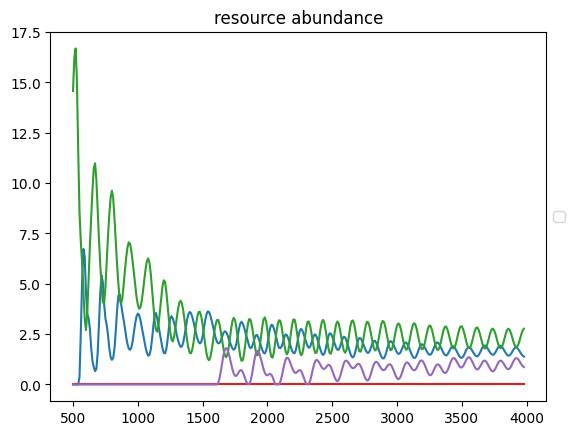

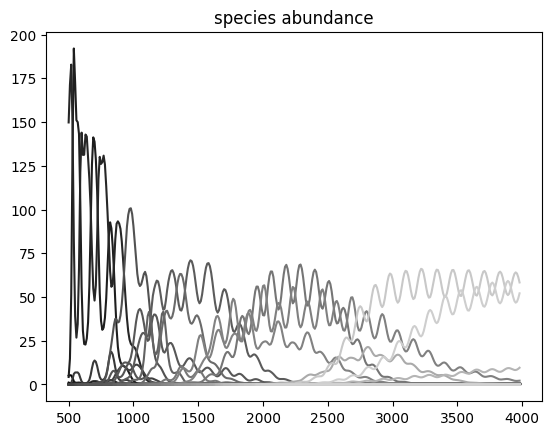

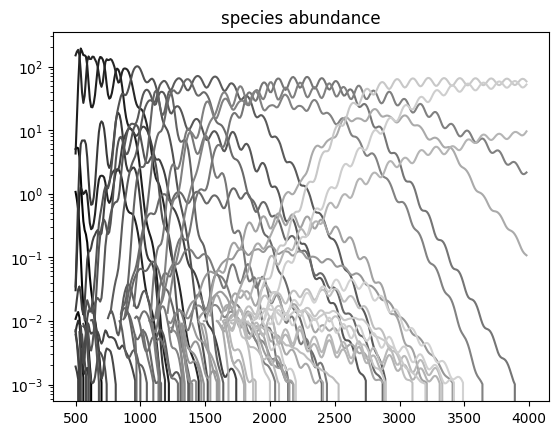

In [43]:
MA_test.show_plots(cutoff=50)

In [44]:
MA_test.print_stats()

Simulation started on  3004_211241
Results stored in:  test/3004_211241_results.csv
D_DIMENSION:  5
P_NORM:  2
GAMMA:  [0.75511326 0.09330305 0.53597178 0.20617115 0.30220227]
DT_TIMESCALE:  1
Living species:  5
death_rate:  0.1
ID, strategies, alive,  abundance at end simulation:
0 [0.31290944 0.3779012  0.01472348 0.72274409 0.48652088] 0 0.0
1 [0.19944902 0.50732827 0.13678497 0.6233076  0.54370546] 0 0.0
2 [0.33085315 0.59575284 0.16038805 0.45611712 0.54940658] 0 0.0
3 [0.31568251 0.70219709 0.20411975 0.4122676  0.44230573] 0 0.0
4 [0.36757625 0.66286654 0.15676959 0.50269881 0.38498423] 0 0.0
5 [0.32342792 0.65659224 0.14860085 0.34258366 0.56994319] 0 0.0
6 [0.09518133 0.5278162  0.1815791  0.69948126 0.43601098] 0 0.0
7 [0.25643388 0.71020765 0.2182034  0.42698087 0.44712567] 0 0.0
8 [0.27463539 0.55197464 0.18700563 0.43923388 0.62610055] 0 0.0
9 [0.34249585 0.60737175 0.         0.3725336  0.61238457] 0 0.0
10 [0.41783498 0.44378864 0.07327772 0.54544353 0.57060257] 0 0.0
11

In [61]:
RNG = np.random.default_rng()
gamma = RNG.uniform(size=100)
gamma = gamma / la.norm(gamma, ord=2)

In [103]:
MA_test_large = ecosystem(gamma, D_DIMENSION=100, K_SPECIES_MAX=10000, MEAN_INTERARRIVAL_TIME=15, P_NORM=2)
MA_test_large.run_sim()

KeyboardInterrupt: 

In [1]:
1/0.001

1000.0

In [28]:
round(np.log10(1/0.001),0)


3.0

In [33]:
""" DO NOT DELETE """

# I repeat

"""
DO
NOT
DELETE
"""

# with open("results/PARAMETER_SETTINGS.csv", 'w', newline='') as csvfile:
#     testwriter = csv.writer(csvfile, delimiter=',')
#     testwriter.writerow(["ID", "GAMMA", "D_DIMENSION", "P_NORM", "NOISE", "MEAN", "SIGMA", "K_SPECIES_MAX", "ABUNDANCE_SPAWN", "ABUNDANCE_DEATH", "DEATH_RATE", "ALPHA", "BETA", "DT_TIMESCALE", "MEAN_INTERARRIVAL_TIME", "SEED", "WITH_RUNOUT", "RUNOUT_SCALING", "MONOD", "MONOD_HALF_VELOCITY", "MONOD_ALPHAMAX", "MONOD_BETAMAX","save_every"])

print("Thank you!")